In [1]:
# Importing necessary libraries for data manipulation and preprocessing
import pandas as pd
import numpy as np

# Import json for storing results
import json

# Importing libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Setting seaborn theme for plots
sns.set_theme()

# Ensure inline plotting in Jupyter notebooks
%matplotlib inline

# Importing text processing libraries
from gensim.parsing.preprocessing import remove_stopwords
import contractions

# Importing libraries for machine learning and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.manifold import TSNE


# Importing libraries for fastText embeddings
import fasttext

# Importing PyTorch and PyTorch Geometric for Graph Neural Networks (GNN)
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, SAGEConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import global_mean_pool

# Importing networkx for graph manipulation
import networkx as nx

# Importing Gensim for word embeddings
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# For progress visualization in loops
from tqdm import tqdm

# For reproducibility
import random

In [2]:
def calculate_accuracy_precision_recall(true_labels, predicted_labels):
    """
    Calculate and return the accuracy, precision, and recall scores.
    
    Parameters:
    true_labels (array-like): True labels of the dataset.
    predicted_labels (array-like): Predicted labels from the model.
    
    Returns:
    tuple: Accuracy, precision, and recall scores.
    """
    return (accuracy_score(true_labels, predicted_labels),
            precision_score(true_labels, predicted_labels),
            recall_score(true_labels, predicted_labels))

def print_evaluation_results(results):
    """
    Print the average and standard deviation of accuracy, precision, and recall scores.
    
    Parameters:
    results (array-like): A list of tuples containing accuracy, precision, and recall scores.
    """
    print('Avg accuracy | Avg precision | Avg recall')
    avg_accuracy, avg_precision, avg_recall = np.mean(results, axis=0)
    std_accuracy, std_precision, std_recall = np.std(results, axis=0)
    print(f'{avg_accuracy:.4f}+-{std_accuracy:.4f}, {avg_precision:.4f}+-{std_precision:.4f}, {avg_recall:.4f}+-{std_recall:.4f}')

def get_random_number():
    """
    Generate a random integer between 0 and 10000.
    
    Returns:
    int: A random integer.
    """
    return random.randint(0, 10000)

# Generating a global random number and a list of 10 random numbers
global_random_number = get_random_number()
global_random_numbers = [get_random_number() for _ in range(10)]

## Load dataset

In [6]:
# Specify the dataset file name
dataset = 'datasets/samples.csv'
dt_name = 'github'

# Load the dataset into a DataFrame
df = pd.read_csv(dataset)

# Filter the DataFrame to include only rows where 'label' is 0 (bug) or 1 (feature)
df = df[(df['label'] == 0) | (df['label'] == 1)]

# Print the number of rows in the filtered DataFrame
len(df)

407799

## Preprocess dataset

In [7]:
# Adding a custom contraction replacement
# The function 'add' adds a new contraction and its expanded form to the contractions library
# '__label__' is the contraction to be added
# 'REMOVED_TOKEN' is the expanded form that will replace '__label__'
contractions.add('__label__', 'REMOVED_TOKEN')

In [8]:
# Fixing contractions in the 'title' and 'body' columns of the DataFrame
# Convert the 'title' column to string type and apply the contractions.fix function to expand contractions
df['title'] = df['title'].astype('str').apply(contractions.fix)

# Convert the 'body' column to string type and apply the contractions.fix function to expand contractions
df['body'] = df['body'].astype('str').apply(contractions.fix)

In [9]:
# Removal of stopwords in the 'title' and 'body' columns of the DataFrame
# Apply the remove_stopwords function to the 'title' column
df['title'] = df['title'].apply(remove_stopwords)

# Apply the remove_stopwords function to the 'body' column
df['body'] = df['body'].apply(remove_stopwords)

## Generate statistics

In [10]:
# Adding new columns to the DataFrame to count the number of words in the 'title' and 'body' columns

# Count the number of words in the 'title' column
df['number_of_words_of_title'] = df['title'].str.split().str.len()

# Count the number of words in the 'body' column
# The same process is applied to the 'body' column
df['number_of_words_of_body'] = df['body'].str.split().str.len()

Text(0.5, 0, 'Number of words of title')

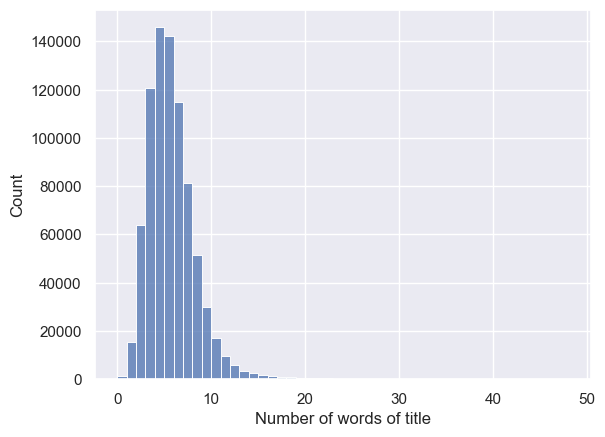

In [8]:
"""
Plotting a histogram of the number of words in the title
    data=df specifies the DataFrame to use

    x='number_of_words_of_title' specifies the column to plot

    kde=False disables the kernel density estimate

    stat='count' specifies that the y-axis should show the count of observations in each bin
        
    binwidth=1 sets the width of each bin to 1
"""

fig = sns.histplot(data=df, x='number_of_words_of_title', kde=False, stat='count', binwidth=1)

# Setting the x-axis label
fig.set_xlabel('Number of words of title')

# Optionally saving the figure to a file (commented out)
# fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

Text(0.5, 0, 'Number of words of body')

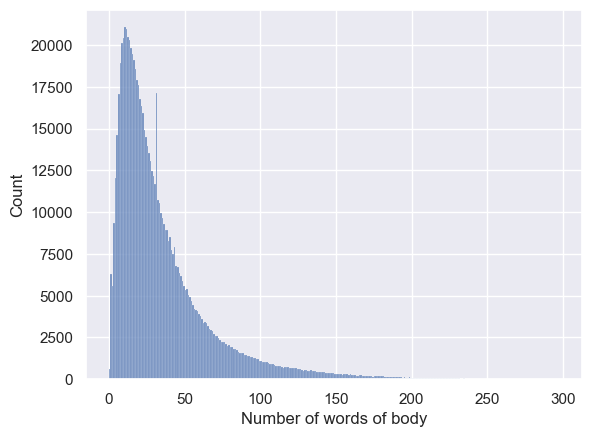

In [9]:
# Plotting a histogram of the number of words in the body

fig = sns.histplot(data=df, x='number_of_words_of_body', kde=False, stat='count', binwidth=1)

# Setting the x-axis label
fig.set_xlabel('Number of words of body')

# Optionally saving the figure to a file (commented out)
# fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

In [32]:
# Generate descriptive statistics for the 'number_of_words_of_title' column
df['number_of_words_of_title'].describe()

count    814322.000000
mean          5.305227
std           2.715007
min           0.000000
25%           4.000000
50%           5.000000
75%           7.000000
max          48.000000
Name: number_of_words_of_title, dtype: float64

In [33]:
# Generate descriptive statistics for the 'number_of_words_of_body' column
df['number_of_words_of_body'].describe()

count    814322.000000
mean         35.422719
std          33.761475
min           0.000000
25%          13.000000
50%          25.000000
75%          45.000000
max         298.000000
Name: number_of_words_of_body, dtype: float64

In [30]:
# Counting the occurrences of each unique value in the 'label' column
# bugs == 0 and feature == 1
df['label'].value_counts()

label
0    464279
1    350043
Name: count, dtype: int64

In [31]:
# Splitting the 'body' column into training and testing sets
# test_size=0.33 specifies that 33% of the data should be used as the test set
# random_state=42 ensures reproducibility of the split
x_train, x_test = train_test_split(df['body'], test_size=0.33, random_state=42)

# Print the size of the training and testing sets
print('Train size', len(x_train))
print('Test size', len(x_test))

Train size 545595
Test size 268727


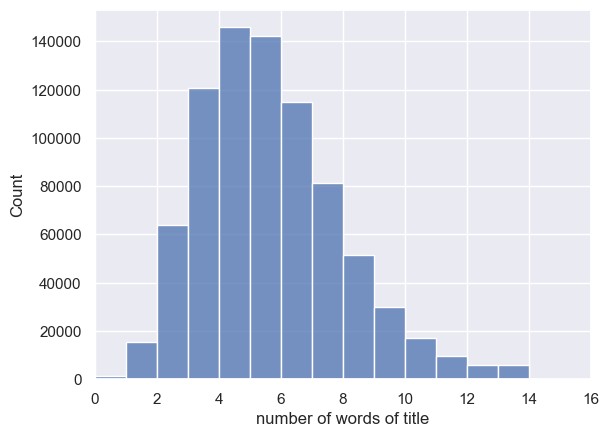

In [14]:
# Set the threshold for the number of words in the title
threshold_title = 15

# Construct a name for the dataset based on parts of the dataset file name
dt_name = ''.join([dataset.split('_')[0], dataset.split('_')[2].split('.')[0]])

# Plotting a histogram for titles with a number of words less than the threshold
fig = sns.histplot(data=df[df['number_of_words_of_title'] < threshold_title], x='number_of_words_of_title', kde=False, stat='count', binwidth=1)

# Setting the x-axis label
fig.set_xlabel('number of words of title')

# Setting the x-axis limits
fig.set_xlim(0,16)

# Saving the figure to a PDF file with the constructed name and specified dpi
fig.get_figure().savefig(f'figures/{dt_name}_number_of_words_of_title_less_than_{threshold_title}.pdf', dpi=500)

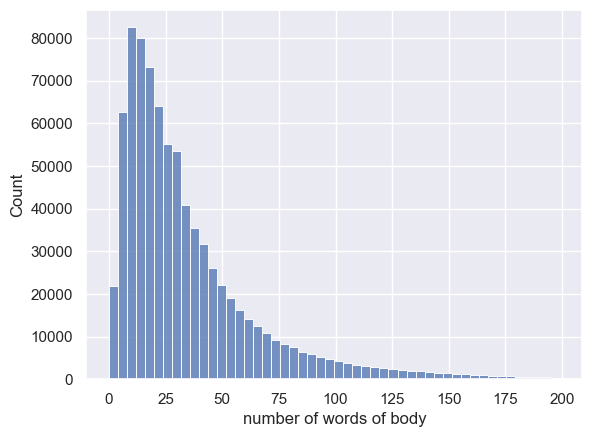

In [70]:
# Set the threshold for the number of words in the body
threshold_body = 200

# Plotting a histogram for bodies with a number of words less than the threshold
fig = sns.histplot(data=df[df['number_of_words_of_body'] < 200], x='number_of_words_of_body', kde=False, stat='count', binwidth=4)

# Setting the x-axis label
fig.set_xlabel('number of words of body')

# Saving the figure to a PDF file with the constructed name and specified dpi
fig.get_figure().savefig(f'figures/{dt_name}_number_of_words_of_body_less_than_{threshold_body}.pdf', dpi=500)

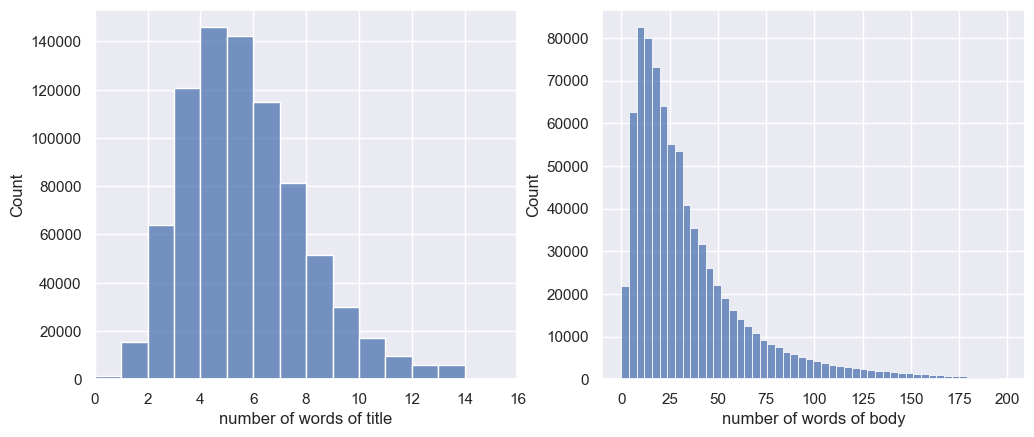

In [16]:
# Plot histograms for the number of words in titles and bodies, and save them as a single PDF file

# Create subplots with 1 row and 2 columns
fig, ax = plt.subplots(1,2)

# Set the figure width to 12 inches
fig.set_figwidth(12)

# Plot histogram for the number of words in the title
sns.histplot(
    data=df[df['number_of_words_of_title'] < threshold_title],
    x='number_of_words_of_title',
    kde=False,
    stat='count',
    binwidth=1,
    ax=ax[0]
    )

# Set the x-axis label and limits for the first subplot
ax[0].set_xlabel('number of words of title')
ax[0].set_xlim(0,16)

# Plot histogram for the number of words in the body
sns.histplot(
    data=df[df['number_of_words_of_body'] < threshold_body],
    x='number_of_words_of_body',
    kde=False,
    stat='count',
    binwidth=4,
    ax=ax[1]
)

# Set the x-axis label for the second subplot
ax[1].set_xlabel('number of words of body')

# Save the figure to a PDF file with the constructed name and specified dpi
fig.savefig(f'figures/{dt_name}_title_words_less_than_{threshold_title}_body_words_less_than_{threshold_body}.pdf', dpi=500)

## Load glove embeddings 100

In [16]:
# Convert GloVe embeddings to word2vec format and load them into a KeyedVectors model

# Convert GloVe format to word2vec format
glove2word2vec('../bug-or-feature2/glove.6B/glove.6B.100d.txt', 'tmpfile_glove')

# Load the converted GloVe embeddings in word2vec format
glove_embeddings_model = KeyedVectors.load_word2vec_format('tmpfile_glove')

C:\Users\hlias\AppData\Local\Temp\ipykernel_44356\3745624638.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec('../bug-or-feature2/glove.6B/glove.6B.100d.txt', 'tmpfile_glove')


In [17]:
def get_word_glove_embedding(word):
    """
    Get the GloVe embedding for a given word.
    
    Parameters:
    word (str): The word for which to get the embedding.
    
    Returns:
    numpy.ndarray: The GloVe embedding vector for the word, or a zero vector if the word is not in the model.
    """

    if word not in glove_embeddings_model:

        # Return a zero vector of size 100 if the word is not in the GloVe model
        return np.zeros(100, dtype='float32')
    
    # Return the GloVe embedding vector for the word
    return glove_embeddings_model.get_vector(word)

In [18]:
def get_sentence_glove_embedding(sentence):
    """
    Get the GloVe embedding for a given sentence by averaging the embeddings of the words in the sentence.
    
    Parameters:
    sentence (str): The sentence for which to get the embedding.
    
    Returns:
    numpy.ndarray: The GloVe embedding vector for the sentence, or a zero vector if the sentence is empty or has no known words.
    """
    # Split the sentence into words and get their embeddings
    word_embeddings = [glove_embeddings_model.get_vector(word) if word in glove_embeddings_model else np.zeros(100, dtype='float32') for word in sentence.split()]

    # Check if the sentence has any words
    if len(word_embeddings) == 0:

        # Return a zero vector of size 100 if the sentence is empty or has no known words
        return np.zeros(100, dtype='float32')
    
    # Calculate the mean of the word embeddings to get the sentence embedding
    return np.mean(word_embeddings, axis=0)

## Train fasttext embeddings

In [19]:
# Prepare data for fastText model training and testing, train the model, and generate word embeddings

# Create a new column 'fasttext_input' formatted for fastText supervised learning
df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']

# Split the 'fasttext_input' column into training and testing sets
train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)

# Save the training and testing data to text files
np.savetxt(f'{dt_name}_train.txt', train_input, fmt='%s')
np.savetxt(f'{dt_name}_test.txt', test_input, fmt='%s')

# Train a fastText supervised model on the training data
# dim=100 specifies the dimension of the word vectors
# epoch=5 specifies the number of training epochs
fasttext_model = fasttext.train_supervised(f'{dt_name}_train.txt', dim=100, epoch=5)

# Test the fastText model on the testing data
fasttext_model.test(f'{dt_name}_test.txt')

# Drop the 'fasttext_input' column from the DataFrame as it is no longer needed
df.drop('fasttext_input', axis=1, inplace=True)

# Generate a dictionary to look up word embeddings using the trained fastText model
embeddings_lookup = {word: fasttext_model.get_word_vector(word) for word in fasttext_model.get_words()}

## Train baseline models

## GloVe + logistic regression classification

In [20]:
# Split the dataset into training and testing sets, and convert sentences to GloVe embeddings

# Split the 'body' column and 'label' column into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)

# Convert training sentences to GloVe embeddings
X_train = [get_sentence_glove_embedding(s) for s in X_train.values]

# Use the get_sentence_glove_embedding function to convert each sentence in X_train to its GloVe embedding
X_test = [get_sentence_glove_embedding(s) for s in X_test.values]

In [32]:
def run_logistic_regression_classifier(use_global_random_number=True):
    """
    Run a logistic regression classifier on the training data and evaluate its performance on the test data.
    
    Parameters:
    use_global_random_number (bool): Whether to use the global random number for the random state.
    
    Returns:
    tuple: Accuracy, precision, and recall scores.
    """
    
    # Determine the random state to use for the classifier
    if use_global_random_number:
        random_state = global_random_number
    else:
        random_state = get_random_number()
    
    # Initialize and fit the logistic regression classifier
    logit_clf = LogisticRegression(random_state=random_state, solver='liblinear').fit(X_train, y_train)

    # Predict labels for the test data
    predicted_labels = logit_clf.predict(X_test)
    pred_probs = logit_clf.predict_proba(X_test)
    
    # Get the true labels for the test data
    true_labels = y_test

    # Calculate accuracy, precision, and recall
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)

    # Print and return results
    print(results)
    return logit_clf, pred_probs, results

In [34]:
# Run the logistic regression classifier and store the results in a list
logit_clf, logit_pred_probs, logit_evaluation_results = run_logistic_regression_classifier()
 

(0.722695320046963, 0.7408314087759815, 0.7013935453776858)


## <font color='red'>GloVe + logistic regression results</font>

In [24]:
# Print the evaluation results of the logistic regression classifier
print_evaluation_results([logit_evaluation_results])

Avg accuracy | Avg precision | Avg recall
0.7227+-0.0000, 0.7408+-0.0000, 0.7014+-0.0000


<Figure size 640x480 with 0 Axes>

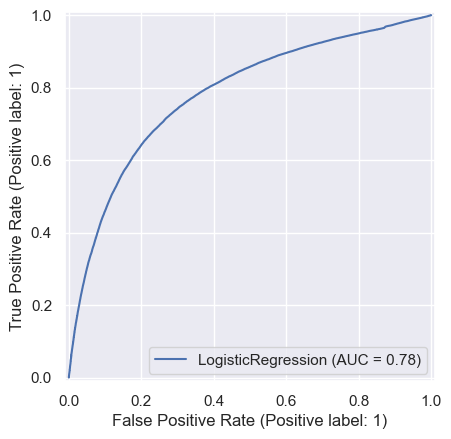

In [38]:
from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(y_test, logit_pred_probs)
# roc_auc = metrics.auc(fpr, tpr)
plt.figure(0).clf()


plt.show()

## GloVe + knn

In [39]:
# Define a function to run a K-Nearest Neighbors classifier and evaluate its performance

def run_knn_regression_classifier():
    """
    Run a K-Nearest Neighbors classifier on the training data and evaluate its performance on the test data.
    
    Returns:
    tuple: Accuracy, precision, and recall scores.
    """

    # Initialize and fit the K-Nearest Neighbors classifier
    knn_clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

    # Predict labels for the test data
    predicted_labels = knn_clf.predict(X_test)

    # Get the true labels for the test data
    true_labels = y_test
    
    # Calculate accuracy, precision, and recall
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)

    # Print and return results    
    print(results)
    return knn_clf, results

In [40]:
# Run the K-Nearest Neighbors classifier and store the evaluation results
knn_clf, knn_evaluation_results = run_knn_regression_classifier()

(0.6919390075348879, 0.7329443061872479, 0.6225037170927962)


## <font color='red'>GloVe + knn results</font>

In [41]:
# Print the evaluation results for K-Nearest Neighbors
print_evaluation_results([knn_evaluation_results])

Avg accuracy | Avg precision | Avg recall
0.6919+-0.0000, 0.7329+-0.0000, 0.6225+-0.0000


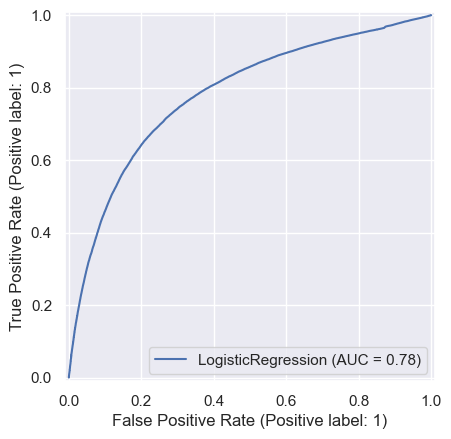

<Figure size 640x480 with 0 Axes>

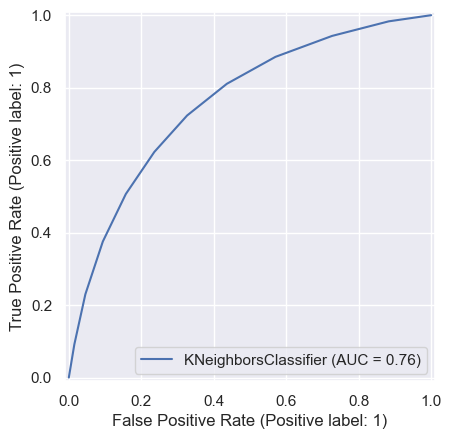

In [44]:
display1 = metrics.RocCurveDisplay.from_estimator(estimator=logit_clf, X=X_test, y=y_test)
display2 = metrics.RocCurveDisplay.from_estimator(estimator=knn_clf, X=X_test, y=y_test)
plt.show()

## Fasttext classification

In [30]:
# Define a function to run a fastText classifier and evaluate its performance

def run_fasttext_classifier():
    """
    Run a fastText classifier on the training data and evaluate its performance on the test data.
    
    Returns:
    tuple: Accuracy, precision, and recall scores.
    """
    
    # Prepare the input data for fastText
    df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']

    # Split the input data into training and testing sets
    train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)

    # Save the training and testing data to text files
    np.savetxt(f'{dt_name}_train.txt', train_input, fmt='%s')
    np.savetxt(f'{dt_name}_test.txt', test_input, fmt='%s')

    # Train a fastText supervised model on the training data
    fasttext_model = fasttext.train_supervised(f'{dt_name}_train.txt', dim=100, epoch=5)

    # Test the fastText model on the testing data (this line can be expanded to capture and report test metrics)
    fasttext_model.test(f'{dt_name}_test.txt')

    # Remove the 'fasttext_input' column from the DataFrame as it is no longer needed
    df.drop('fasttext_input', axis=1, inplace=True)

    # Create a dictionary to look up word embeddings using the trained fastText model
    embeddings_lookup = {word: fasttext_model.get_word_vector(word) for word in fasttext_model.get_words()}

    # Split the original DataFrame into training and testing sets
    _, test_df = train_test_split(df, test_size=0.33, random_state=42)

    # Predict labels for the test data using the fastText model
    predicted_labels = [int(res[0].split('__label__')[1]) for res in fasttext_model.predict(test_df['body'].values.tolist())[0]]

    # Get the true labels for the test data
    true_labels = test_df['label'].values
    
    # Calculate accuracy, precision, and recall
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)

    # Print and return results
    print(results)
    return results

In [31]:
# Initialize an empty list to store the evaluation results of the fastText classifier
fasttext_evaluation_results = []

# Run the fastText classifier multiple times using different random numbers from global_random_numbers
for num in global_random_numbers:
    fasttext_evaluation_results.append(run_fasttext_classifier())

(0.9499864174422369, 0.9489480524042008, 0.9340858802378648)
(0.9501538736338365, 0.9482678538564681, 0.9352440879546398)
(0.9502096923643698, 0.9479606311623264, 0.9357194717189877)
(0.9502096923643698, 0.9484318297365053, 0.9352008712487899)
(0.9503138873280318, 0.947652040030793, 0.9363158622597151)
(0.9502171348617742, 0.947687137931638, 0.9360392753422763)
(0.9498710587324682, 0.9488316546509892, 0.9339303000968054)
(0.9500720061623878, 0.9477633502902523, 0.9355984649426082)
(0.9501910861208587, 0.9472846662994343, 0.9364195823537547)
(0.9501538736338365, 0.9481421775203918, 0.9353823814133592)


## <font color='red'>Fasttext results</font>

In [32]:
# Print the evaluation results for the fastText classifier
print_evaluation_results(fasttext_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.9501+-0.0001, 0.9481+-0.0005, 0.9354+-0.0008


## MLP

In [33]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split the 'body' and 'label' columns into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)

# Convert sentences to GloVe embeddings
x_train = [get_sentence_glove_embedding(s) for s in x_train.values]
x_test = [get_sentence_glove_embedding(s) for s in x_test.values]

# Convert data to PyTorch tensors and set data types to float
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train.values).float()


x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test.values).float()

# Move tensors to the selected device (GPU or CPU)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# Set the batch size for the DataLoader
BATCH_SIZE = 255

# Create a TensorDataset and DataLoader for the training data
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)

# Create a TensorDataset for the test data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# generate test dataset
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

cuda


C:\Users\hlias\AppData\Local\Temp\ipykernel_26756\3901747008.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:277.)
  x_train = torch.tensor(x_train).float()


In [34]:
# Define the Multi-Layer Perceptron (MLP) model
class MLP(torch.nn.Module):
    def __init__(self) : 
        """
        Initialize the MLP model.
        """
        super(MLP, self).__init__()
        # Define the first linear layer with 100 input features and 250 output features
        self.linear1 = torch.nn.Linear(100 , 250)

        # Define the second linear layer with 250 input features and 1 output feature
        self.linear2 = torch.nn.Linear(250, 1)

        # Define the sigmoid activation function
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        """
        Define the forward pass of the MLP model.
        
        Parameters:
        x (torch.Tensor): Input tensor.
        
        Returns:
        torch.Tensor: Output tensor after applying the linear layers, ReLU activation, dropout, and sigmoid activation.
        """
        # Pass the input through the first linear layer
        out = self.linear1(x)

        # Apply ReLU activation function
        out = F.relu(out)

        # Apply dropout with a probability of 0.5 (only during training)
        out = F.dropout(out, p=0.5, training=self.training)
        
        # Pass the output through the second linear layer
        out = self.linear2(out)

        # Apply sigmoid activation function

        out = self.sigmoid(out)
        return out

In [35]:
def run_mlp_classifier():
    """
    Train and evaluate the Multi-Layer Perceptron (MLP) model on the dataset.

    Returns:
    tuple: Accuracy, precision, and recall scores.
    """
    # Initialize the MLP model and move it to the selected device
    mlp = MLP().to(device)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

    # Set the model to training mode
    mlp.train()

    # Run the training loop for 50 epochs
    for epoch in range(0, 50):
        # Iterate over the DataLoader for training data
        for i, (inputs, targets) in enumerate(train_dataloader):

            # Get inputs and targets, and move them to the selected device
            targets = targets.squeeze()

            # Perform forward pass
            outputs = mlp(inputs)
            outputs = outputs.squeeze()
            # Compute loss
            loss = loss_function(outputs, targets)
            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()
            # Zero the gradients
            optimizer.zero_grad()
        
        # Print the loss for each epoch
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')
    
    # Training process is complete
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    # Evaluate the model on the test data
    with torch.no_grad():
        mlp.eval()
        
        # Get predictions for the test data
        pred = mlp(test_dataset.tensors[0].to(device))
        y_true = test_dataset.tensors[1].tolist()
        y_pred = torch.round(torch.tensor(pred.tolist()).squeeze())

        # Calculate accuracy, precision, and recall
        results = calculate_accuracy_precision_recall(y_true, y_pred)
    
    # Print and return the evaluation results
    print(results)
    return results

In [36]:
# Initialize an empty list to store the evaluation results of the MLP classifier
mlp_evaluation_results = []

# Run the MLP classifier multiple times using different random numbers from global_random_numbers
for num in global_random_numbers:
    # Set the random seed for reproducibility
    torch.manual_seed(num)

    # Run the MLP classifier and append the results to the list
    mlp_evaluation_results.append(run_mlp_classifier())

Epoch: 0, Epoch loss 0.34649139642715454
Epoch: 1, Epoch loss 0.31532150506973267
Epoch: 2, Epoch loss 0.31881749629974365
Epoch: 3, Epoch loss 0.3198372423648834
Epoch: 4, Epoch loss 0.31870171427726746
Epoch: 5, Epoch loss 0.3078313171863556
Epoch: 6, Epoch loss 0.3018990159034729
Epoch: 7, Epoch loss 0.2999004125595093
Epoch: 8, Epoch loss 0.3099447190761566
Epoch: 9, Epoch loss 0.30315351486206055
Epoch: 10, Epoch loss 0.32896357774734497
Epoch: 11, Epoch loss 0.2972140312194824
Epoch: 12, Epoch loss 0.33046087622642517
Epoch: 13, Epoch loss 0.28164687752723694
Epoch: 14, Epoch loss 0.3177281618118286
Epoch: 15, Epoch loss 0.28657639026641846
Epoch: 16, Epoch loss 0.3038586974143982
Epoch: 17, Epoch loss 0.2801733613014221
Epoch: 18, Epoch loss 0.29372742772102356
Epoch: 19, Epoch loss 0.2975265681743622
Epoch: 20, Epoch loss 0.30658096075057983
Epoch: 21, Epoch loss 0.29344433546066284
Epoch: 22, Epoch loss 0.30912426114082336
Epoch: 23, Epoch loss 0.289203405380249
Epoch: 24, Epo

## <font color='red'>GloVe + MLP results</font>

In [37]:
# Print the evaluation results for the MLP classifier
print_evaluation_results(mlp_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.8979+-0.0002, 0.8656+-0.0008, 0.9030+-0.0009


## Train our model

In [38]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_graph_of_words(text, window_size):
    """
    Create a graph of words from the given text using a sliding window approach.
    
    Parameters:
    text (str): The input text.
    window_size (int): The size of the sliding window.
    
    Returns:
    networkx.Graph: The graph of words.
    """

    # Split the text into words
    text = text.split()
    # Initialize an empty graph
    G = nx.Graph()


    for i, word in enumerate(text):
        
        # Get the word embedding or use a zero vector if the word is not found
        embedding = embeddings_lookup.get(word, np.zeros(100, dtype='float32'))
        
        # Add the word as a node with its embedding as an attribute
        G.add_node(word, x=embedding)

        # Connect the word to the next words in the window
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch(text, window_size):
    """
    Convert the graph of words to a PyTorch Geometric graph.
    
    Parameters:
    text (str): The input text.
    window_size (int): The size of the sliding window.
    
    Returns:
    torch_geometric.data.Data: The PyTorch Geometric graph.
    """
    return from_networkx(create_graph_of_words(text, window_size))

def generate_pytorch_geometric_graphs(window_size):
    """
    Generate PyTorch Geometric graphs for all texts in the DataFrame.
    
    Parameters:
    window_size (int): The size of the sliding window.
    
    Returns:
    list: A list of PyTorch Geometric graphs with labels.
    """

    # Initialize an empty list to store the graphs
    pyg_graphs = []

    for s in tqdm(df['body'].values):
        
        # Convert each text to a PyTorch Geometric graph and append to the list
        pyg_graphs.append(create_graph_of_words_for_pytorch(s, window_size))
    
    print('Finished generating graphs...')

    # Add labels to the graphs
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    # Filter out graphs with no nodes
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    
    return pyg_graphs

class GATClassifier(torch.nn.Module):
    def __init__(self):
        """
        Initialize the GATClassifier model.
        """

        super().__init__()

        # Define the first GAT layer with 100 input features, 10 output features, and 3 heads        
        self.conv1 = GATConv(100, 10, heads=3)
        # Define a linear layer to reduce the output to 1 feature
        self.linear1 = torch.nn.Linear(10*3, 1)
        # Define the sigmoid activation function
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        """
        Define the forward pass of the GATClassifier model.
        
        Parameters:
        data (torch_geometric.data.Data): The input data.
        batch (torch.Tensor): The batch tensor.
        
        Returns:
        tuple: Hidden representations and output predictions.
        """
        # Get the node features and edge indices from the data
        x, edge_index = data.x, data.edge_index

        # Apply the first GAT layer with ELU activation
        x = F.elu(self.conv1(x, edge_index))
        # Perform global mean pooling to get a graph-level representation
        x = global_mean_pool(x, batch)
        # Apply dropout with a probability of 0.5 during training
        h = F.dropout(x, p=0.5, training=self.training)
        # Pass the pooled representation through the linear layer
        x = self.linear1(h)
        # Apply the sigmoid activation function
        x = self.sigmoid(x)
               
        return h, x

In [39]:
# Generate PyTorch Geometric graphs with a specified window size
pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=7)

100%|██████████| 814322/814322 [50:20<00:00, 269.59it/s]  


finished...


In [40]:
# Split the PyTorch Geometric graphs into training and testing sets
train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)

In [42]:
def run_gat_classifier(train_pyg_graphs, test_pyg_graphs, train_batch_size=300, learning_rate=0.001, num_epoch=10):
    """
    Train and evaluate the GATClassifier model on the dataset.
    
    Parameters:
    train_pyg_graphs (list): List of PyTorch Geometric graphs for training.
    test_pyg_graphs (list): List of PyTorch Geometric graphs for testing.
    train_batch_size (int): Batch size for training.
    learning_rate (float): Learning rate for the optimizer.
    num_epoch (int): Number of epochs for training.
    
    Returns:
    dict: A dictionary containing the trained model and evaluation results.
    """

    # Create DataLoader for training and testing datasets
    train_loader = DataLoader(train_pyg_graphs, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs, batch_size=200, shuffle=False)
    
    # Initialize the GATClassifier model and move it to the selected device
    gat_model = GATClassifier().to(device)
    print(gat_model)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)
    
    # Set the model to training mode
    gat_model.train()
    for epoch in range(0, num_epoch):

        # Iterate in batches over the training dataset
        for i, data in enumerate(train_loader):
            data = data.to(device)
            try:
                # Perform a single forward pass
                _, out = gat_model(data, data.batch)
            except Exception as e:
                print(f"Error during forward pass: {e}")
                print(data)
                print(data.x)
                print(data.y)
            
            out = out.squeeze()
            y = data.y.squeeze()
            
            # Compute the loss            
            loss = loss_function(out, y)
            # Perform backward pass            
            loss.backward()
            # Update parameters based on gradients
            optimizer.step()
            # Clear gradients
            optimizer.zero_grad()  # Clear gradients.
        
        # Print the loss for each epoch
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    # Training process is complete
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    # Initialize lists to store true and predicted labels
    true_labels = []
    pred_labels = []

    # Set the model to evaluation mode
    with torch.no_grad():
        gat_model.eval()

        # Iterate in batches over the testing dataset
        for i, data in enumerate(test_loader):
            data = data.to(device)
            # Perform a forward pass
            _, out = gat_model(data, data.batch)
            # Store the predicted and true labels
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())

    # Calculate accuracy, precision, and recall
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)

    # Print and return the evaluation results    
    print(results)
    return {
        'model': gat_model,
        'results': results
    }

In [43]:
# Initialize an empty list to store the evaluation results of the GAT classifier
gat_evaluation_results = []

# Run the GAT classifier multiple times using different random numbers from global_random_numbers
for num in global_random_numbers:
    # Set the random seed for reproducibility
    torch.manual_seed(num)

    # Run the GAT classifier and append the results to the list
    gat_evaluation_results.append(run_gat_classifier(train_pyg_graphs, test_pyg_graphs)['results'])

d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.1309354156255722
Epoch: 1, Epoch loss 0.12907011806964874
Epoch: 2, Epoch loss 0.1299525648355484
Epoch: 3, Epoch loss 0.13657023012638092
Epoch: 4, Epoch loss 0.12903249263763428
Epoch: 5, Epoch loss 0.13796553015708923
Epoch: 6, Epoch loss 0.13074252009391785
Epoch: 7, Epoch loss 0.11916991323232651
Epoch: 8, Epoch loss 0.1449357569217682
Epoch: 9, Epoch loss 0.12775111198425293
Training process has finished.
Final loss 0.12775111198425293
(0.9562874496791757, 0.9362477384608912, 0.9639407040313288)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.13800501823425293
Epoch: 1, Epoch loss 0.13694794476032257
Epoch: 2, Epoch loss 0.13454577326774597
Epoch: 3, Epoch loss 0.13353629410266876
Epoch: 4, Epoch loss 0.13932548463344574
Epoch: 5, Epoch loss 0.12905916571617126
Epoch: 6, Epoch loss 0.13956786692142487
Epoch: 7, Epoch loss 0.1405162811279297
Epoch: 8, Epoch loss 0.13477346301078796
Epoch: 9, Epoch loss 0.1285066306591034
Training process has finished.
Final loss 0.1285066306591034
(0.9562539334964454, 0.9362135415790094, 0.9638973843581324)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.13689370453357697
Epoch: 1, Epoch loss 0.14150631427764893
Epoch: 2, Epoch loss 0.13093245029449463
Epoch: 3, Epoch loss 0.1322852224111557
Epoch: 4, Epoch loss 0.1302155703306198
Epoch: 5, Epoch loss 0.12874458730220795
Epoch: 6, Epoch loss 0.13717646896839142
Epoch: 7, Epoch loss 0.1176430955529213
Epoch: 8, Epoch loss 0.15418104827404022
Epoch: 9, Epoch loss 0.12711165845394135
Training process has finished.
Final loss 0.12711165845394135
(0.956280001638569, 0.9361218841225908, 0.9640706630509179)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.13301853835582733
Epoch: 1, Epoch loss 0.12681537866592407
Epoch: 2, Epoch loss 0.13188275694847107
Epoch: 3, Epoch loss 0.13365085422992706
Epoch: 4, Epoch loss 0.1384844034910202
Epoch: 5, Epoch loss 0.13886311650276184
Epoch: 6, Epoch loss 0.12696956098079681
Epoch: 7, Epoch loss 0.13233178853988647
Epoch: 8, Epoch loss 0.1390506476163864
Epoch: 9, Epoch loss 0.13322824239730835
Training process has finished.
Final loss 0.13322824239730835
(0.9562576575167487, 0.9360306178239475, 0.9641226466587536)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.12950605154037476
Epoch: 1, Epoch loss 0.1369953155517578
Epoch: 2, Epoch loss 0.1275673657655716
Epoch: 3, Epoch loss 0.12399923801422119
Epoch: 4, Epoch loss 0.1298011690378189
Epoch: 5, Epoch loss 0.14094536006450653
Epoch: 6, Epoch loss 0.13681644201278687
Epoch: 7, Epoch loss 0.14063645899295807
Epoch: 8, Epoch loss 0.1330345869064331
Epoch: 9, Epoch loss 0.13404004275798798
Training process has finished.
Final loss 0.13404004275798798
(0.956239037415232, 0.9364905603179683, 0.9635334991032828)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.1340053528547287
Epoch: 1, Epoch loss 0.13960668444633484
Epoch: 2, Epoch loss 0.1288483738899231
Epoch: 3, Epoch loss 0.1374773234128952
Epoch: 4, Epoch loss 0.1284351348876953
Epoch: 5, Epoch loss 0.14428888261318207
Epoch: 6, Epoch loss 0.13718512654304504
Epoch: 7, Epoch loss 0.14853395521640778
Epoch: 8, Epoch loss 0.13090720772743225
Epoch: 9, Epoch loss 0.12927238643169403
Training process has finished.
Final loss 0.12927238643169403
(0.9562464854558387, 0.9359996635545462, 0.9641313105933929)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.14049987494945526
Epoch: 1, Epoch loss 0.1333644539117813
Epoch: 2, Epoch loss 0.13647465407848358
Epoch: 3, Epoch loss 0.1275818794965744
Epoch: 4, Epoch loss 0.12623155117034912
Epoch: 5, Epoch loss 0.13757550716400146
Epoch: 6, Epoch loss 0.123783178627491
Epoch: 7, Epoch loss 0.13476958870887756
Epoch: 8, Epoch loss 0.1346001923084259
Epoch: 9, Epoch loss 0.12975387275218964
Training process has finished.
Final loss 0.12975387275218964
(0.9562539334964454, 0.9361548169962137, 0.9639666958352466)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.13097445666790009
Epoch: 1, Epoch loss 0.13893306255340576
Epoch: 2, Epoch loss 0.14186033606529236
Epoch: 3, Epoch loss 0.1349816620349884
Epoch: 4, Epoch loss 0.13339672982692719
Epoch: 5, Epoch loss 0.1327415108680725
Epoch: 6, Epoch loss 0.1264263540506363
Epoch: 7, Epoch loss 0.13309277594089508
Epoch: 8, Epoch loss 0.12427650392055511
Epoch: 9, Epoch loss 0.13126379251480103
Training process has finished.
Final loss 0.13126379251480103
(0.9562651055573554, 0.936039029314043, 0.9641313105933929)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.12464720010757446
Epoch: 1, Epoch loss 0.131797194480896
Epoch: 2, Epoch loss 0.12713372707366943
Epoch: 3, Epoch loss 0.12900011241436005
Epoch: 4, Epoch loss 0.12324773520231247
Epoch: 5, Epoch loss 0.13517051935195923
Epoch: 6, Epoch loss 0.12875567376613617
Epoch: 7, Epoch loss 0.13756795227527618
Epoch: 8, Epoch loss 0.12873288989067078
Epoch: 9, Epoch loss 0.1311935931444168
Training process has finished.
Final loss 0.1311935931444168
(0.956291173699479, 0.9363217075141395, 0.9638627286195753)
GATClassifier(
  (conv1): SGConv(100, 50, K=1)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.13325348496437073
Epoch: 1, Epoch loss 0.13575594127178192
Epoch: 2, Epoch loss 0.12955448031425476
Epoch: 3, Epoch loss 0.1290789246559143
Epoch: 4, Epoch loss 0.13780882954597473
Epoch: 5, Epoch loss 0.13763636350631714
Epoch: 6, Epoch loss 0.11957187205553055
Epoch: 7, Epoch loss 0.13225266337394714
Epoch: 8, Epoch loss 0.13150662183761597
Epoch: 9, Epoch loss 0.14058923721313477
Training process has finished.
Final loss 0.14058923721313477
(0.9562613815370521, 0.9363100749095195, 0.9638020810771003)


## <font color='red'>Our approach results</font>

In [44]:
# Print the evaluation results for the GAT classifier
print_evaluation_results(gat_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.9563+-0.0000, 0.9362+-0.0001, 0.9639+-0.0002


In [45]:
# Clean up the memory by deleting the variables
del pytorch_geometric_graphs
del train_pyg_graphs
del test_pyg_graphs

## Glove + GATConv

In [46]:
def create_graph_of_words_glove(text, window_size):
    """
    Create a graph of words from the given text using a sliding window approach and GloVe embeddings.
    
    Parameters:
    text (str): The input text.
    window_size (int): The size of the sliding window.
    
    Returns:
    networkx.Graph: The graph of words.
    """

    # Split the text into words
    text = text.split()

    # Initialize an empty graph
    G = nx.Graph()
    for i, word in enumerate(text):

        # Get the GloVe embedding for the word
        embedding = get_word_glove_embedding(word)

        # Add the word as a node with its embedding as an attribute
        G.add_node(word, x=embedding)

        # Connect the word to the next words in the window
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    
    return G

def create_graph_of_words_for_pytorch_glove(text, window_size):
    """
    Convert the GloVe graph of words to a PyTorch Geometric graph.
    
    Parameters:
    text (str): The input text.
    window_size (int): The size of the sliding window.
    
    Returns:
    torch_geometric.data.Data: The PyTorch Geometric graph.
    """
    return from_networkx(create_graph_of_words_glove(text, window_size))

def generate_pytorch_geometric_graphs_glove(window_size):
    """
    Generate PyTorch Geometric graphs for all texts in the DataFrame using GloVe embeddings.
    
    Parameters:
    window_size (int): The size of the sliding window.
    
    Returns:
    list: A list of PyTorch Geometric graphs with labels.
    """

    # Initialize an empty list to store the graphs
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        # Convert each text to a PyTorch Geometric graph and append to the list
        pyg_graphs.append(create_graph_of_words_for_pytorch_glove(s, window_size))
    
    print('Finished generating graphs...')

    # Add labels to the graphs
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    # Filter out graphs with no nodes
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]

    return pyg_graphs

class GATGloveClassifier(torch.nn.Module):
    def __init__(self):
        """
        Initialize the GATGloveClassifier model.
        """

        super().__init__()

        # Define the first GAT layer with 100 input features, 10 output features, and 3 heads
        self.conv1 = GATConv(100, 10, heads=3)
        # Define a linear layer to reduce the output to 1 feature
        self.linear1 = torch.nn.Linear(10*3, 1)
        # Define the sigmoid activation function
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        """
        Define the forward pass of the GATGloveClassifier model.
        
        Parameters:
        data (torch_geometric.data.Data): The input data.
        batch (torch.Tensor): The batch tensor.
        
        Returns:
        torch.Tensor: Output predictions.
        """

        # Get the node features and edge indices from the data
        x, edge_index = data.x, data.edge_index
        
        # Apply the first GAT layer with ELU activation
        x = F.elu(self.conv1(x, edge_index))
        # Perform global mean pooling to get a graph-level representation
        x = global_mean_pool(x, batch)
        # Apply dropout with a probability of 0.5 during training
        x = F.dropout(x, p=0.5, training=self.training)
        # Pass the pooled representation through the linear layer
        x = self.linear1(x)
        # Apply the sigmoid activation function
        x = self.sigmoid(x)
                
        return x

In [47]:
# Generate PyTorch Geometric graphs using GloVe embeddings with a specified window size
pytorch_geometric_graphs_glove = generate_pytorch_geometric_graphs_glove(window_size=7)

  0%|          | 0/814322 [00:00<?, ?it/s]

100%|██████████| 814322/814322 [49:52<00:00, 272.08it/s]  


finished...


In [48]:
# Split the PyTorch Geometric graphs into training and testing sets
train_pyg_graphs_glove, test_pyg_graphs_glove = train_test_split(pytorch_geometric_graphs_glove, test_size=0.33, random_state=42)

In [50]:
def run_gat_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    """
    Train and evaluate the GATGloveClassifier model on the dataset.
    
    Parameters:
    train_batch_size (int): Batch size for training.
    learning_rate (float): Learning rate for the optimizer.
    num_epoch (int): Number of epochs for training.
    
    Returns:
    dict: A dictionary containing the trained model and evaluation results.
    """

    # Create DataLoader for training and testing datasets
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    # Initialize the GATGloveClassifier model and move it to the selected device
    gat_model = GATGloveClassifier().to(device)
    print(gat_model)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    # Set the model to training mode
    gat_model.train()
    for epoch in range(0, num_epoch):

        # Iterate in batches over the training dataset
        for i, data in enumerate(train_loader):

            data = data.to(device)
            try:
                # Perform a single forward pass
                out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(f"Error during forward pass: {e}")
                print(data)
                print(data.x)
                print(data.y)
            
            out = out.squeeze()
            y = data.y.squeeze()

            # Compute the loss
            loss = loss_function(out, y)
            # Perform backward pass
            loss.backward()
            # Update parameters based on gradients
            optimizer.step()
            # Clear gradients
            optimizer.zero_grad()
        
        # Print the loss for each epoch
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    # Training process is complete
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    # Initialize lists to store true and predicted labels
    true_labels = []
    pred_labels = []

    # Set the model to evaluation mode
    with torch.no_grad():
        gat_model.eval()

        # Iterate in batches over the testing dataset
        for i, data in enumerate(test_loader):
            data = data.to(device)

            # Perform a forward pass
            out = gat_model(data, data.batch)
            # Store the predicted and true labels
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    # Calculate accuracy, precision, and recall
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)

    # Print and return the evaluation results
    print(results)
    
    return results

In [51]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize an empty list to store the evaluation results of the GATGlove classifier
gat_glove_evaluation_results = []

# Run the GATGlove classifier multiple times using different random numbers from global_random_numbers
for num in global_random_numbers:

    # Set the random seed for reproducibility
    torch.manual_seed(num)
    # Run the GATGlove classifier and append the results to the list
    gat_glove_evaluation_results.append(run_gat_glove_classifier())

d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.35227927565574646
Epoch: 1, Epoch loss 0.31315115094184875
Epoch: 2, Epoch loss 0.2646562457084656
Epoch: 3, Epoch loss 0.2439373880624771
Epoch: 4, Epoch loss 0.24959613382816315
Epoch: 5, Epoch loss 0.25913360714912415
Epoch: 6, Epoch loss 0.21713615953922272
Epoch: 7, Epoch loss 0.21979926526546478
Epoch: 8, Epoch loss 0.213609516620636
Epoch: 9, Epoch loss 0.22013787925243378
Training process has finished.
Final loss 0.22013787925243378
(0.9025125964986761, 0.8706812763235502, 0.9080669895426309)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.29174745082855225
Epoch: 1, Epoch loss 0.21594645082950592
Epoch: 2, Epoch loss 0.22814933955669403
Epoch: 3, Epoch loss 0.26995325088500977
Epoch: 4, Epoch loss 0.25209030508995056
Epoch: 5, Epoch loss 0.20063059031963348
Epoch: 6, Epoch loss 0.22835570573806763
Epoch: 7, Epoch loss 0.2409788817167282
Epoch: 8, Epoch loss 0.2512624263763428
Epoch: 9, Epoch loss 0.21829092502593994
Training process has finished.
Final loss 0.21829092502593994
(0.9021215743668235, 0.8702543738681111, 0.9075991370721099)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.2500040531158447
Epoch: 1, Epoch loss 0.23244565725326538
Epoch: 2, Epoch loss 0.23040299117565155
Epoch: 3, Epoch loss 0.23840582370758057
Epoch: 4, Epoch loss 0.2726360261440277
Epoch: 5, Epoch loss 0.2239445149898529
Epoch: 6, Epoch loss 0.272415429353714
Epoch: 7, Epoch loss 0.29982897639274597
Epoch: 8, Epoch loss 0.28170663118362427
Epoch: 9, Epoch loss 0.25492122769355774
Training process has finished.
Final loss 0.25492122769355774
(0.9025870769047433, 0.8723418455454796, 0.905944325556008)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.2335517555475235
Epoch: 1, Epoch loss 0.2871447503566742
Epoch: 2, Epoch loss 0.2438572347164154
Epoch: 3, Epoch loss 0.30298471450805664
Epoch: 4, Epoch loss 0.2397795468568802
Epoch: 5, Epoch loss 0.22993656992912292
Epoch: 6, Epoch loss 0.24506451189517975
Epoch: 7, Epoch loss 0.277348130941391
Epoch: 8, Epoch loss 0.22615455090999603
Epoch: 9, Epoch loss 0.20262083411216736
Training process has finished.
Final loss 0.20262083411216736
(0.8998685420832915, 0.8677322079799297, 0.9049912927456876)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.24773946404457092
Epoch: 1, Epoch loss 0.3030746877193451
Epoch: 2, Epoch loss 0.28835412859916687
Epoch: 3, Epoch loss 0.2587588131427765
Epoch: 4, Epoch loss 0.24187447130680084
Epoch: 5, Epoch loss 0.26838719844818115
Epoch: 6, Epoch loss 0.27713239192962646
Epoch: 7, Epoch loss 0.27770423889160156
Epoch: 8, Epoch loss 0.264424592256546
Epoch: 9, Epoch loss 0.29180580377578735
Training process has finished.
Final loss 0.29180580377578735
(0.90210667828561, 0.8721421533425742, 0.904913317333934)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.2616770267486572
Epoch: 1, Epoch loss 0.2756071090698242
Epoch: 2, Epoch loss 0.2688077986240387
Epoch: 3, Epoch loss 0.304704874753952
Epoch: 4, Epoch loss 0.2557269334793091
Epoch: 5, Epoch loss 0.26556825637817383
Epoch: 6, Epoch loss 0.26250070333480835
Epoch: 7, Epoch loss 0.2696766257286072
Epoch: 8, Epoch loss 0.2596307694911957
Epoch: 9, Epoch loss 0.30906713008880615
Training process has finished.
Final loss 0.30906713008880615
(0.9028477583259784, 0.8740756249738285, 0.9042461943667097)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.24998345971107483
Epoch: 1, Epoch loss 0.32814231514930725
Epoch: 2, Epoch loss 0.276746541261673
Epoch: 3, Epoch loss 0.26513126492500305
Epoch: 4, Epoch loss 0.2730291783809662
Epoch: 5, Epoch loss 0.3003321886062622
Epoch: 6, Epoch loss 0.31255248188972473
Epoch: 7, Epoch loss 0.2717522978782654
Epoch: 8, Epoch loss 0.23230460286140442
Epoch: 9, Epoch loss 0.28817060589790344
Training process has finished.
Final loss 0.28817060589790344
(0.9039724124575927, 0.873918520928758, 0.9075211616603565)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3087293803691864
Epoch: 1, Epoch loss 0.3333565592765808
Epoch: 2, Epoch loss 0.2869607210159302
Epoch: 3, Epoch loss 0.24840418994426727
Epoch: 4, Epoch loss 0.28674519062042236
Epoch: 5, Epoch loss 0.2652907073497772
Epoch: 6, Epoch loss 0.26156264543533325
Epoch: 7, Epoch loss 0.3052360713481903
Epoch: 8, Epoch loss 0.2780141830444336
Epoch: 9, Epoch loss 0.2739991247653961
Training process has finished.
Final loss 0.2739991247653961
(0.9020731621028798, 0.8690812413553202, 0.9091239895686227)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.29576021432876587
Epoch: 1, Epoch loss 0.29608529806137085
Epoch: 2, Epoch loss 0.2896295189857483
Epoch: 3, Epoch loss 0.29751548171043396
Epoch: 4, Epoch loss 0.2498352974653244
Epoch: 5, Epoch loss 0.28264304995536804
Epoch: 6, Epoch loss 0.2853836417198181
Epoch: 7, Epoch loss 0.27772796154022217
Epoch: 8, Epoch loss 0.2585822343826294
Epoch: 9, Epoch loss 0.30311354994773865
Training process has finished.
Final loss 0.30311354994773865
(0.9021774346713738, 0.8694358574850201, 0.9089073912026407)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.23962394893169403
Epoch: 1, Epoch loss 0.1936521828174591
Epoch: 2, Epoch loss 0.21231508255004883
Epoch: 3, Epoch loss 0.19383782148361206
Epoch: 4, Epoch loss 0.23405997455120087
Epoch: 5, Epoch loss 0.21464839577674866
Epoch: 6, Epoch loss 0.21160274744033813
Epoch: 7, Epoch loss 0.24407966434955597
Epoch: 8, Epoch loss 0.23700521886348724
Epoch: 9, Epoch loss 0.23519086837768555
Training process has finished.
Final loss 0.23519086837768555
(0.9027285896762709, 0.8727304600435751, 0.9057883747325011)


## <font color='red'>GloVe + GATConv results</font>

In [52]:
# Print the evaluation results for the GATGlove classifier
print_evaluation_results(gat_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.9023+-0.0010, 0.8712+-0.0020, 0.9067+-0.0017


## Glove + GCNonv

In [ ]:
def create_graph_of_words_glove(text, window_size):
    text = text.split()
    G = nx.Graph()
    for i, word in enumerate(text):
        #embedding = fasttext_model.get_word_vector(word)
        embedding = get_word_glove_embedding(word)
        G.add_node(word, x=embedding)
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch_glove(text, window_size):
    return from_networkx(create_graph_of_words_glove(text, window_size))

def generate_pytorch_geometric_graphs_glove(window_size):
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        pyg_graphs.append(create_graph_of_words_for_pytorch_glove(s, window_size))
    print('finished...')
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    return pyg_graphs


class GCNGloveClassifier(torch.nn.Module):
    def __init__(self):
        """
        Initialize the GCNGloveClassifier model.
        """

        super().__init__()
        
        # Define the first GCN layer with 100 input features and 10 output features
        self.conv1 = GCNConv(100, 10)
        # Define a linear layer to reduce the output to 1 feature
        self.linear1 = torch.nn.Linear(10, 1)
        # Define the sigmoid activation function
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        """
        Define the forward pass of the GCNGloveClassifier model.
        
        Parameters:
        data (torch_geometric.data.Data): The input data.
        batch (torch.Tensor): The batch tensor.
        
        Returns:
        torch.Tensor: Output predictions.
        """
        # Get the node features and edge indices from the data
        x, edge_index = data.x, data.edge_index
        
        # Apply the first GCN layer with ELU activation
        x = F.elu(self.conv1(x, edge_index))
        # Perform global mean pooling to get a graph-level representation
        x = global_mean_pool(x, batch)
        # Apply dropout with a probability of 0.5 during training
        x = F.dropout(x, p=0.5, training=self.training)
        # Pass the pooled representation through the linear layer
        x = self.linear1(x)
        # Apply the sigmoid activation function
        x = self.sigmoid(x)
        
        return x

In [54]:
def run_gcn_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    """
    Train and evaluate the GCNGloveClassifier model on the dataset.
    
    Parameters:
    train_batch_size (int): Batch size for training.
    learning_rate (float): Learning rate for the optimizer.
    num_epoch (int): Number of epochs for training.
    
    Returns:
    dict: A dictionary containing the trained model and evaluation results.
    """

    # Create DataLoader for training and testing datasets
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    # Initialize the GCNGloveClassifier model and move it to the selected device
    model = GCNGloveClassifier().to(device)
    print(model)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set the model to training mode
    model.train()
    for epoch in range(0, num_epoch):

        # Iterate in batches over the training dataset
        for i, data in enumerate(train_loader):
            data = data.to(device)
            try:
                # Perform a single forward pass
                out = model(data, data.batch)
            except Exception as e:
                print(f"Error during forward pass: {e}")
                print(data)
                print(data.x)
                print(data.y)
            

            out = out.squeeze()
            y = data.y.squeeze()

            # Compute the loss
            loss = loss_function(out, y)
            # Perform backward pass
            loss.backward()
            # Update parameters based on gradients
            optimizer.step()
            # Clear gradients
            optimizer.zero_grad()
        
        # Print the loss for each epoch
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    # Training process is complete
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    # Initialize lists to store true and predicted labels
    true_labels = []
    pred_labels = []

    # Set the model to evaluation mode
    with torch.no_grad():
        model.eval()

        # Iterate in batches over the testing dataset
        for i, data in enumerate(test_loader):
            data = data.to(device)

            # Perform a forward pass
            out = model(data, data.batch)
            # Store the predicted and true labels
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    # Calculate accuracy, precision, and recall
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    # Print and return the evaluation results
    print(results)
    
    return results

In [55]:
# Initialize an empty list to store the evaluation results of the GCNGlove classifier
gcn_glove_evaluation_results = []

# Run the GCNGlove classifier multiple times using different random numbers from global_random_numbers
for num in global_random_numbers:
    # Set the random seed for reproducibility
    torch.manual_seed(num)

    # Run the GCNGlove classifier and append the results to the list
    gcn_glove_evaluation_results.append(run_gcn_glove_classifier())

GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3589356541633606
Epoch: 1, Epoch loss 0.3863030970096588
Epoch: 2, Epoch loss 0.3678418695926666
Epoch: 3, Epoch loss 0.2862997055053711
Epoch: 4, Epoch loss 0.3405810594558716
Epoch: 5, Epoch loss 0.3283419609069824
Epoch: 6, Epoch loss 0.32735422253608704
Epoch: 7, Epoch loss 0.3750915229320526
Epoch: 8, Epoch loss 0.3285547196865082
Epoch: 9, Epoch loss 0.3145905137062073
Training process has finished.
Final loss 0.3145905137062073
(0.8693650917784804, 0.8364518074307347, 0.8652584884899628)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.28413230180740356
Epoch: 1, Epoch loss 0.363935261964798
Epoch: 2, Epoch loss 0.3455824553966522
Epoch: 3, Epoch loss 0.32411542534828186
Epoch: 4, Epoch loss 0.36809438467025757
Epoch: 5, Epoch loss 0.30379095673561096
Epoch: 6, Epoch loss 0.3353199362754822
Epoch: 7, Epoch loss 0.31713271141052246
Epoch: 8, Epoch loss 0.2981986105442047
Epoch: 9, Epoch loss 0.34556907415390015
Training process has finished.
Final loss 0.34556907415390015
(0.8704227135446343, 0.833606421714664, 0.8727441280182983)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.31601977348327637
Epoch: 1, Epoch loss 0.3371032476425171
Epoch: 2, Epoch loss 0.32729649543762207
Epoch: 3, Epoch loss 0.3275023400783539
Epoch: 4, Epoch loss 0.3180147409439087
Epoch: 5, Epoch loss 0.3319082260131836
Epoch: 6, Epoch loss 0.3485787510871887
Epoch: 7, Epoch loss 0.3081396818161011
Epoch: 8, Epoch loss 0.34996795654296875
Epoch: 9, Epoch loss 0.371731162071228
Training process has finished.
Final loss 0.371731162071228
(0.8694879844484912, 0.83622110485497, 0.8659689311303835)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3895280361175537
Epoch: 1, Epoch loss 0.359671950340271
Epoch: 2, Epoch loss 0.3533032536506653
Epoch: 3, Epoch loss 0.36619728803634644
Epoch: 4, Epoch loss 0.33061400055885315
Epoch: 5, Epoch loss 0.3411228656768799
Epoch: 6, Epoch loss 0.34635046124458313
Epoch: 7, Epoch loss 0.3381805419921875
Epoch: 8, Epoch loss 0.29396969079971313
Epoch: 9, Epoch loss 0.3485795855522156
Training process has finished.
Final loss 0.3485795855522156
(0.8701806522249159, 0.834031296386901, 0.8713752263452924)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3394639790058136
Epoch: 1, Epoch loss 0.32156482338905334
Epoch: 2, Epoch loss 0.3225545585155487
Epoch: 3, Epoch loss 0.3611326813697815
Epoch: 4, Epoch loss 0.3531118333339691
Epoch: 5, Epoch loss 0.3122679591178894
Epoch: 6, Epoch loss 0.3427259027957916
Epoch: 7, Epoch loss 0.3446439206600189
Epoch: 8, Epoch loss 0.29060986638069153
Epoch: 9, Epoch loss 0.29894325137138367
Training process has finished.
Final loss 0.29894325137138367
(0.8702476845903764, 0.8340339095469055, 0.8715658329073566)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3561432957649231
Epoch: 1, Epoch loss 0.3442133963108063
Epoch: 2, Epoch loss 0.3457798659801483
Epoch: 3, Epoch loss 0.320742666721344
Epoch: 4, Epoch loss 0.298397958278656
Epoch: 5, Epoch loss 0.30253124237060547
Epoch: 6, Epoch loss 0.36876967549324036
Epoch: 7, Epoch loss 0.3164588212966919
Epoch: 8, Epoch loss 0.33649274706840515
Epoch: 9, Epoch loss 0.3166925013065338
Training process has finished.
Final loss 0.3166925013065338
(0.8699572110067144, 0.8338766538094645, 0.8709680214172464)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3120622932910919
Epoch: 1, Epoch loss 0.3377474248409271
Epoch: 2, Epoch loss 0.3335561752319336
Epoch: 3, Epoch loss 0.3747056722640991
Epoch: 4, Epoch loss 0.34378865361213684
Epoch: 5, Epoch loss 0.36561840772628784
Epoch: 6, Epoch loss 0.310109943151474
Epoch: 7, Epoch loss 0.309733510017395
Epoch: 8, Epoch loss 0.33592063188552856
Epoch: 9, Epoch loss 0.3323802947998047
Training process has finished.
Final loss 0.3323802947998047
(0.8695252246515248, 0.8359032217625674, 0.8665667426204937)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3606937825679779
Epoch: 1, Epoch loss 0.3293420970439911
Epoch: 2, Epoch loss 0.3142077922821045
Epoch: 3, Epoch loss 0.34218302369117737
Epoch: 4, Epoch loss 0.31417447328567505
Epoch: 5, Epoch loss 0.336719274520874
Epoch: 6, Epoch loss 0.3596979081630707
Epoch: 7, Epoch loss 0.3649207353591919
Epoch: 8, Epoch loss 0.3285011649131775
Epoch: 9, Epoch loss 0.37002691626548767
Training process has finished.
Final loss 0.37002691626548767
(0.8701285159406689, 0.8340729803488922, 0.8711586279793105)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3249402344226837
Epoch: 1, Epoch loss 0.35044336318969727
Epoch: 2, Epoch loss 0.3545190989971161
Epoch: 3, Epoch loss 0.3272184133529663
Epoch: 4, Epoch loss 0.39767521619796753
Epoch: 5, Epoch loss 0.3449556529521942
Epoch: 6, Epoch loss 0.34682783484458923
Epoch: 7, Epoch loss 0.34759554266929626
Epoch: 8, Epoch loss 0.26585251092910767
Epoch: 9, Epoch loss 0.32907500863075256
Training process has finished.
Final loss 0.32907500863075256
(0.870232788509163, 0.8342722965740978, 0.8711499640446713)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3092505931854248
Epoch: 1, Epoch loss 0.3215392827987671
Epoch: 2, Epoch loss 0.31502795219421387
Epoch: 3, Epoch loss 0.3298693895339966
Epoch: 4, Epoch loss 0.29834842681884766
Epoch: 5, Epoch loss 0.3375053107738495
Epoch: 6, Epoch loss 0.3189999461174011
Epoch: 7, Epoch loss 0.3265329599380493
Epoch: 8, Epoch loss 0.3130887746810913
Epoch: 9, Epoch loss 0.3602704405784607
Training process has finished.
Final loss 0.3602704405784607
(0.8702960968543201, 0.833305761881917, 0.8728480952339696)


## <font color='red'>GloVe + GCNConv results</font>

In [56]:
# Print the evaluation results for the GCNGlove classifier
print_evaluation_results(gcn_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.8700+-0.0004, 0.8346+-0.0011, 0.8700+-0.0027


## Glove + GraphConv

In [57]:
class GraphConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        """
        Initialize the GraphConvGloveClassifier model.
        """

        super().__init__()
        
        # Define the first GraphConv layer with 100 input features and 10 output features
        self.conv1 = GraphConv(100, 10, aggr='mean')
        # Define a linear layer to reduce the output to 1 feature
        self.linear1 = torch.nn.Linear(10, 1)
        # Define the sigmoid activation function
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        """
        Define the forward pass of the GraphConvGloveClassifier model.
        
        Parameters:
        data (torch_geometric.data.Data): The input data.
        batch (torch.Tensor): The batch tensor.
        
        Returns:
        torch.Tensor: Output predictions.
        """

        # Get the node features and edge indices from the data
        x, edge_index = data.x, data.edge_index
        
        # Apply the first GraphConv layer with ELU activation
        x = F.elu(self.conv1(x, edge_index))
        # Perform global mean pooling to get a graph-level representation
        x = global_mean_pool(x, batch)
         # Apply dropout with a probability of 0.5 during training
        x = F.dropout(x, p=0.5, training=self.training)
        # Pass the pooled representation through the linear layer
        x = self.linear1(x)
        # Apply the sigmoid activation function
        x = self.sigmoid(x)
        
        return x

In [58]:
def run_graphconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    """
    Train and evaluate the GraphConvGloveClassifier model on the dataset.
    
    Parameters:
    train_batch_size (int): Batch size for training.
    learning_rate (float): Learning rate for the optimizer.
    num_epoch (int): Number of epochs for training.
    
    Returns:
    dict: A dictionary containing the trained model and evaluation results.
    """

    # Create DataLoader for training and testing datasets
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)

    # Initialize the GraphConvGloveClassifier model and move it to the selected device
    model = GraphConvGloveClassifier().to(device)
    print(model)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set the model to training mode
    model.train()
    for epoch in range(0, num_epoch):

        # Iterate in batches over the training dataset
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                # Perform a single forward pass
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(f"Error during forward pass: {e}")
                print(data)
                print(data.x)
                print(data.y)
            
            out = out.squeeze()
            y = data.y.squeeze()

            # Compute the loss
            loss = loss_function(out, y)
            # Perform backward pass
            loss.backward()
            # Update parameters based on gradients
            optimizer.step()
            # Clear gradients
            optimizer.zero_grad()
        
        # Print the loss for each epoch
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    # Training process is complete
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    # Initialize lists to store true and predicted labels
    true_labels = []
    pred_labels = []

    # Set the model to evaluation mode
    with torch.no_grad():
        model.eval()

        # Iterate in batches over the testing dataset
        for i, data in enumerate(test_loader):
            data = data.to(device)

            # Perform a forward pass
            out = model(data, data.batch)
            # Store the predicted and true labels
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    # Calculate accuracy, precision, and recall
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)

    # Print and return the evaluation results
    print(results)
    
    return results

In [59]:
# Initialize an empty list to store the evaluation results of the GraphConvGlove classifier
graphconv_glove_evaluation_results = []

# Run the GraphConvGlove classifier multiple times using different random numbers from global_random_numbers
for num in global_random_numbers:

    # Set the random seed for reproducibility
    torch.manual_seed(num)

    # Run the GraphConvGlove classifier and append the results to the list
    graphconv_glove_evaluation_results.append(run_graphconv_glove_classifier())

GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.34583187103271484
Epoch: 1, Epoch loss 0.38582849502563477
Epoch: 2, Epoch loss 0.3712547719478607
Epoch: 3, Epoch loss 0.2853983938694
Epoch: 4, Epoch loss 0.3316771686077118
Epoch: 5, Epoch loss 0.32763347029685974
Epoch: 6, Epoch loss 0.30653226375579834
Epoch: 7, Epoch loss 0.3305608928203583
Epoch: 8, Epoch loss 0.2896248996257782
Epoch: 9, Epoch loss 0.2932763993740082
Training process has finished.
Final loss 0.2932763993740082
(0.8965839561757291, 0.8645835933015548, 0.9004340631254277)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.2698754370212555
Epoch: 1, Epoch loss 0.36869943141937256
Epoch: 2, Epoch loss 0.3455663025379181
Epoch: 3, Epoch loss 0.3182150721549988
Epoch: 4, Epoch loss 0.3462524116039276
Epoch: 5, Epoch loss 0.26225075125694275
Epoch: 6, Epoch loss 0.3212631642818451
Epoch: 7, Epoch loss 0.2599586844444275
Epoch: 8, Epoch loss 0.25410017371177673
Epoch: 9, Epoch loss 0.31891950964927673
Training process has finished.
Final loss 0.31891950964927673
(0.8950906240340822, 0.8594143914053618, 0.9037696779615495)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3199544847011566
Epoch: 1, Epoch loss 0.3490891456604004
Epoch: 2, Epoch loss 0.33173882961273193
Epoch: 3, Epoch loss 0.3459712564945221
Epoch: 4, Epoch loss 0.3094628155231476
Epoch: 5, Epoch loss 0.3360065817832947
Epoch: 6, Epoch loss 0.3085222840309143
Epoch: 7, Epoch loss 0.3090551495552063
Epoch: 8, Epoch loss 0.35507795214653015
Epoch: 9, Epoch loss 0.3473779261112213
Training process has finished.
Final loss 0.3473779261112213
(0.8969191180030314, 0.865834438245816, 0.8995763335961393)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.39031657576560974
Epoch: 1, Epoch loss 0.37478315830230713
Epoch: 2, Epoch loss 0.37693506479263306
Epoch: 3, Epoch loss 0.36168256402015686
Epoch: 4, Epoch loss 0.3304784297943115
Epoch: 5, Epoch loss 0.34099945425987244
Epoch: 6, Epoch loss 0.3404448330402374
Epoch: 7, Epoch loss 0.30464714765548706
Epoch: 8, Epoch loss 0.28124359250068665
Epoch: 9, Epoch loss 0.30392977595329285
Training process has finished.
Final loss 0.30392977595329285
(0.8967552611096836, 0.8632940338202275, 0.902755997608754)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.317775696516037
Epoch: 1, Epoch loss 0.32138410210609436
Epoch: 2, Epoch loss 0.3415150046348572
Epoch: 3, Epoch loss 0.3599475622177124
Epoch: 4, Epoch loss 0.3824840188026428
Epoch: 5, Epoch loss 0.3101208209991455
Epoch: 6, Epoch loss 0.31035614013671875
Epoch: 7, Epoch loss 0.3524891138076782
Epoch: 8, Epoch loss 0.2884294092655182
Epoch: 9, Epoch loss 0.25743475556373596
Training process has finished.
Final loss 0.25743475556373596
(0.8960179050896185, 0.8649836902567012, 0.8983027352041656)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.36461514234542847
Epoch: 1, Epoch loss 0.37653839588165283
Epoch: 2, Epoch loss 0.36817440390586853
Epoch: 3, Epoch loss 0.3408699631690979
Epoch: 4, Epoch loss 0.28441235423088074
Epoch: 5, Epoch loss 0.3145332634449005
Epoch: 6, Epoch loss 0.36330780386924744
Epoch: 7, Epoch loss 0.36037907004356384
Epoch: 8, Epoch loss 0.3400175869464874
Epoch: 9, Epoch loss 0.31274786591529846
Training process has finished.
Final loss 0.31274786591529846
(0.896624920399066, 0.8641355819556368, 0.9011878254390449)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.29670873284339905
Epoch: 1, Epoch loss 0.31712156534194946
Epoch: 2, Epoch loss 0.3268141448497772
Epoch: 3, Epoch loss 0.393007755279541
Epoch: 4, Epoch loss 0.3074609339237213
Epoch: 5, Epoch loss 0.36599600315093994
Epoch: 6, Epoch loss 0.2758771479129791
Epoch: 7, Epoch loss 0.25282156467437744
Epoch: 8, Epoch loss 0.2954574525356293
Epoch: 9, Epoch loss 0.29528388381004333
Training process has finished.
Final loss 0.29528388381004333
(0.8960514212723488, 0.8632484309102381, 0.900875923792031)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3339235186576843
Epoch: 1, Epoch loss 0.3132684528827667
Epoch: 2, Epoch loss 0.31112030148506165
Epoch: 3, Epoch loss 0.3760725259780884
Epoch: 4, Epoch loss 0.311789333820343
Epoch: 5, Epoch loss 0.3183078467845917
Epoch: 6, Epoch loss 0.3544090688228607
Epoch: 7, Epoch loss 0.3605400621891022
Epoch: 8, Epoch loss 0.3151685297489166
Epoch: 9, Epoch loss 0.38760697841644287
Training process has finished.
Final loss 0.38760697841644287
(0.8963791350590443, 0.8660020390085739, 0.8978522106029232)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.30762773752212524
Epoch: 1, Epoch loss 0.3506236672401428
Epoch: 2, Epoch loss 0.35901930928230286
Epoch: 3, Epoch loss 0.32299551367759705
Epoch: 4, Epoch loss 0.4037542939186096
Epoch: 5, Epoch loss 0.3434319496154785
Epoch: 6, Epoch loss 0.3701242208480835
Epoch: 7, Epoch loss 0.328785240650177
Epoch: 8, Epoch loss 0.26913297176361084
Epoch: 9, Epoch loss 0.341808944940567
Training process has finished.
Final loss 0.341808944940567
(0.896043973231742, 0.8650707562913024, 0.8982507515963299)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.299258291721344
Epoch: 1, Epoch loss 0.3226686120033264
Epoch: 2, Epoch loss 0.30756595730781555
Epoch: 3, Epoch loss 0.3268621265888214
Epoch: 4, Epoch loss 0.29837098717689514
Epoch: 5, Epoch loss 0.3340603709220886
Epoch: 6, Epoch loss 0.3010823130607605
Epoch: 7, Epoch loss 0.33884695172309875
Epoch: 8, Epoch loss 0.28382277488708496
Epoch: 9, Epoch loss 0.3482878804206848
Training process has finished.
Final loss 0.3482878804206848
(0.8944091283185676, 0.8596828964001554, 0.9014823992167803)


## <font color='red'>GloVe + GraphConv results</font>

In [60]:
# Print the evaluation results for the GraphConvGlove classifier
print_evaluation_results(graphconv_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.8961+-0.0007, 0.8636+-0.0022, 0.9004+-0.0019


## Glove + SAGEConv

In [61]:
class SAGEConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        """
        Initialize the SAGEConvGloveClassifier model.
        """

        super().__init__()

        # Define the first SAGEConv layer with 100 input features and 10 output features
        self.conv1 = SAGEConv(100, 10)
        # Define a linear layer to reduce the output to 1 feature
        self.linear1 = torch.nn.Linear(10, 1)
        # Define the sigmoid activation function
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        """
        Define the forward pass of the SAGEConvGloveClassifier model.
        
        Parameters:
        data (torch_geometric.data.Data): The input data.
        batch (torch.Tensor): The batch tensor.
        
        Returns:
        torch.Tensor: Output predictions.
        """

        # Get the node features and edge indices from the data
        x, edge_index = data.x, data.edge_index
        
        # Apply the first SAGEConv layer with ELU activation
        x = F.elu(self.conv1(x, edge_index))
        # Perform global mean pooling to get a graph-level representation
        x = global_mean_pool(x, batch)
        # Apply dropout with a probability of 0.5 during training
        x = F.dropout(x, p=0.5, training=self.training)
        # Pass the pooled representation through the linear layer
        x = self.linear1(x)
        # Apply the sigmoid activation function
        x = self.sigmoid(x)
        
        return x

In [62]:
def run_sageconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    """
    Train and evaluate the SAGEConvGloveClassifier model on the dataset.
    
    Parameters:
    train_batch_size (int): Batch size for training.
    learning_rate (float): Learning rate for the optimizer.
    num_epoch (int): Number of epochs for training.
    
    Returns:
    dict: A dictionary containing the trained model and evaluation results.
    """

    # Create DataLoader for training and testing datasets
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    # Initialize the SAGEConvGloveClassifier model and move it to the selected device
    model = SAGEConvGloveClassifier().to(device)
    print(model)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set the model to training mode
    model.train()
    for epoch in range(0, num_epoch):

        # Iterate in batches over the training dataset
        for i, data in enumerate(train_loader):
            data = data.to(device)
            try:
                # Perform a single forward pass
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(f"Error during forward pass: {e}")
                print(data)
                print(data.x)
                print(data.y)
            
            out = out.squeeze()
            y = data.y.squeeze()

            # Compute the loss
            loss = loss_function(out, y)
            # Perform backward pass
            loss.backward()
            # Update parameters based on gradients
            optimizer.step()
            # Clear gradients
            optimizer.zero_grad()
        
        # Print the loss for each epoch
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    # Training process is complete
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    # Initialize lists to store true and predicted labels
    true_labels = []
    pred_labels = []

    # Set the model to evaluation mode
    with torch.no_grad():
        model.eval()

        # Iterate in batches over the testing dataset
        for i, data in enumerate(test_loader):
            data = data.to(device)

            # Perform a forward pass
            out = model(data, data.batch)
            # Store the predicted and true labels
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    # Calculate accuracy, precision, and recall
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    # Print and return the evaluation results
    print(results)
    
    return results

In [63]:
# Initialize an empty list to store the evaluation results of the SAGEConvGlove classifier
sageconv_glove_evaluation_results = []

# Run the SAGEConvGlove classifier multiple times using different random numbers from global_random_numbers
for num in global_random_numbers:
    # Set the random seed for reproducibility
    torch.manual_seed(num)

    # Run the SAGEConvGlove classifier and append the results to the list
    sageconv_glove_evaluation_results.append(run_sageconv_glove_classifier())

SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.34583187103271484
Epoch: 1, Epoch loss 0.38582849502563477
Epoch: 2, Epoch loss 0.3712548315525055
Epoch: 3, Epoch loss 0.2853983938694
Epoch: 4, Epoch loss 0.3316771388053894
Epoch: 5, Epoch loss 0.32763341069221497
Epoch: 6, Epoch loss 0.3065322935581207
Epoch: 7, Epoch loss 0.3305608332157135
Epoch: 8, Epoch loss 0.2896248698234558
Epoch: 9, Epoch loss 0.29327651858329773
Training process has finished.
Final loss 0.29327651858329773
(0.8965839561757291, 0.8645835933015548, 0.9004340631254277)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.2698754370212555
Epoch: 1, Epoch loss 0.36869943141937256
Epoch: 2, Epoch loss 0.3455663323402405
Epoch: 3, Epoch loss 0.3182150423526764
Epoch: 4, Epoch loss 0.3462523818016052
Epoch: 5, Epoch loss 0.26225075125694275
Epoch: 6, Epoch loss 0.3212631642818451
Epoch: 7, Epoch loss 0.2599586844444275
Epoch: 8, Epoch loss 0.25410017371177673
Epoch: 9, Epoch loss 0.31891950964927673
Training process has finished.
Final loss 0.31891950964927673
(0.8950906240340822, 0.8594143914053618, 0.9037696779615495)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.31995442509651184
Epoch: 1, Epoch loss 0.349089115858078
Epoch: 2, Epoch loss 0.3317388892173767
Epoch: 3, Epoch loss 0.3459712564945221
Epoch: 4, Epoch loss 0.3094627857208252
Epoch: 5, Epoch loss 0.33600661158561707
Epoch: 6, Epoch loss 0.3085222840309143
Epoch: 7, Epoch loss 0.3090551197528839
Epoch: 8, Epoch loss 0.35507792234420776
Epoch: 9, Epoch loss 0.34737783670425415
Training process has finished.
Final loss 0.34737783670425415
(0.8969191180030314, 0.865834438245816, 0.8995763335961393)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.39031657576560974
Epoch: 1, Epoch loss 0.37478315830230713
Epoch: 2, Epoch loss 0.37693506479263306
Epoch: 3, Epoch loss 0.36168259382247925
Epoch: 4, Epoch loss 0.3304784595966339
Epoch: 5, Epoch loss 0.34099942445755005
Epoch: 6, Epoch loss 0.3404448628425598
Epoch: 7, Epoch loss 0.30464714765548706
Epoch: 8, Epoch loss 0.28124359250068665
Epoch: 9, Epoch loss 0.30392974615097046
Training process has finished.
Final loss 0.30392974615097046
(0.8967552611096836, 0.8632940338202275, 0.902755997608754)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.317775696516037
Epoch: 1, Epoch loss 0.32138410210609436
Epoch: 2, Epoch loss 0.3415150046348572
Epoch: 3, Epoch loss 0.3599475920200348
Epoch: 4, Epoch loss 0.3824840188026428
Epoch: 5, Epoch loss 0.3101207911968231
Epoch: 6, Epoch loss 0.31035614013671875
Epoch: 7, Epoch loss 0.35248908400535583
Epoch: 8, Epoch loss 0.2884294092655182
Epoch: 9, Epoch loss 0.25743475556373596
Training process has finished.
Final loss 0.25743475556373596
(0.8960179050896185, 0.8649836902567012, 0.8983027352041656)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3646150827407837
Epoch: 1, Epoch loss 0.37653839588165283
Epoch: 2, Epoch loss 0.3681744635105133
Epoch: 3, Epoch loss 0.3408699333667755
Epoch: 4, Epoch loss 0.28441235423088074
Epoch: 5, Epoch loss 0.3145332932472229
Epoch: 6, Epoch loss 0.36330780386924744
Epoch: 7, Epoch loss 0.36037907004356384
Epoch: 8, Epoch loss 0.3400175869464874
Epoch: 9, Epoch loss 0.31274786591529846
Training process has finished.
Final loss 0.31274786591529846
(0.896624920399066, 0.8641355819556368, 0.9011878254390449)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.29670873284339905
Epoch: 1, Epoch loss 0.31712156534194946
Epoch: 2, Epoch loss 0.32681411504745483
Epoch: 3, Epoch loss 0.393007755279541
Epoch: 4, Epoch loss 0.3074609339237213
Epoch: 5, Epoch loss 0.36599597334861755
Epoch: 6, Epoch loss 0.27587711811065674
Epoch: 7, Epoch loss 0.25282156467437744
Epoch: 8, Epoch loss 0.2954574227333069
Epoch: 9, Epoch loss 0.29528388381004333
Training process has finished.
Final loss 0.29528388381004333
(0.8960514212723488, 0.8632484309102381, 0.900875923792031)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.3339235186576843
Epoch: 1, Epoch loss 0.3132685124874115
Epoch: 2, Epoch loss 0.31112030148506165
Epoch: 3, Epoch loss 0.3760725259780884
Epoch: 4, Epoch loss 0.31178930401802063
Epoch: 5, Epoch loss 0.3183078467845917
Epoch: 6, Epoch loss 0.3544090688228607
Epoch: 7, Epoch loss 0.3605400025844574
Epoch: 8, Epoch loss 0.3151685893535614
Epoch: 9, Epoch loss 0.38760697841644287
Training process has finished.
Final loss 0.38760697841644287
(0.8963791350590443, 0.8660020390085739, 0.8978522106029232)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.30762770771980286
Epoch: 1, Epoch loss 0.3506236672401428
Epoch: 2, Epoch loss 0.3590182960033417
Epoch: 3, Epoch loss 0.32299548387527466
Epoch: 4, Epoch loss 0.40375426411628723
Epoch: 5, Epoch loss 0.3434319496154785
Epoch: 6, Epoch loss 0.3701242208480835
Epoch: 7, Epoch loss 0.328785240650177
Epoch: 8, Epoch loss 0.26913297176361084
Epoch: 9, Epoch loss 0.3418089747428894
Training process has finished.
Final loss 0.3418089747428894
(0.896043973231742, 0.8650707562913024, 0.8982507515963299)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10, aggr=mean)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


d:\Development\bug-or-feature\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Epoch loss 0.299258291721344
Epoch: 1, Epoch loss 0.32266858220100403
Epoch: 2, Epoch loss 0.30756595730781555
Epoch: 3, Epoch loss 0.326862096786499
Epoch: 4, Epoch loss 0.29837098717689514
Epoch: 5, Epoch loss 0.3340603709220886
Epoch: 6, Epoch loss 0.3010822832584381
Epoch: 7, Epoch loss 0.33884698152542114
Epoch: 8, Epoch loss 0.28382283449172974
Epoch: 9, Epoch loss 0.3482878506183624
Training process has finished.
Final loss 0.3482878506183624
(0.8944091283185676, 0.8596828964001554, 0.9014823992167803)


## <font color='red'>GloVe + SAGEConv results</font>

In [64]:
# Print the evaluation results for the SAGEConvGlove classifier
print_evaluation_results(sageconv_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.8961+-0.0007, 0.8636+-0.0022, 0.9004+-0.0019


## Store Results

In [65]:
# Summarize results from different models
overall_results = {}
for model in [('LR', logit_evaluation_results),
              ('KNN', knn_evaluation_results),
              ('FastText', fasttext_evaluation_results),
              ('MLP', mlp_evaluation_results),
              ('GAT', gat_evaluation_results),
              ('GAT_GloVe', gat_glove_evaluation_results),
              ('GCN_GloVe', gcn_glove_evaluation_results),
              ('Graph_Conv', graphconv_glove_evaluation_results),
              ('Sage_Conv', sageconv_glove_evaluation_results)]:
    
    # Extract accuracy, precision, and recall results for each model
    accuracy_results = [result[0] for result in model[1]]
    precision_results = [result[1] for result in model[1]]
    recall_results = [result[2] for result in model[1]]
    
    # Store results in a dictionary
    overall_results[model[0]] = {'Accuracy': accuracy_results,
                                 'Precision': precision_results,
                                 'Recall': recall_results}

# Store results for all models and all metrics to json file in the folder "results"
with open(f"results/results_{dt_name}.json", "w") as outfile:
    json.dump(overall_results, outfile) 

{'LR': {'Accuracy': [0.8674640062219279], 'Precision': [0.8419591767016825], 'Recall': [0.8521037892407689]}, 'KNN': {'Accuracy': [0.8894119310675891], 'Precision': [0.8563766289750306], 'Recall': [0.8928830728806527]}, 'FastText': {'Accuracy': [0.9499864174422369, 0.9501538736338365, 0.9502096923643698, 0.9502096923643698, 0.9503138873280318, 0.9502171348617742, 0.9498710587324682, 0.9500720061623878, 0.9501910861208587, 0.9501538736338365], 'Precision': [0.9489480524042008, 0.9482678538564681, 0.9479606311623264, 0.9484318297365053, 0.947652040030793, 0.947687137931638, 0.9488316546509892, 0.9477633502902523, 0.9472846662994343, 0.9481421775203918], 'Recall': [0.9340858802378648, 0.9352440879546398, 0.9357194717189877, 0.9352008712487899, 0.9363158622597151, 0.9360392753422763, 0.9339303000968054, 0.9355984649426082, 0.9364195823537547, 0.9353823814133592]}, 'MLP': {'Accuracy': [0.8978480018755094, 0.8977289219170385, 0.897963360585278, 0.8978740506164249, 0.8977475281605496, 0.89777

In [66]:
# Delete the variables to free up memory
del pytorch_geometric_graphs_glove
del train_pyg_graphs_glove
del test_pyg_graphs_glove

# Parameter Sensitivity

In [67]:
# Parameter Sensitivity Analysis
# This section performs a sensitivity analysis to evaluate the impact of different sliding window sizes 
# on the performance of the GAT classifier. The experiments will help determine the optimal sliding window size 
# for generating PyTorch Geometric graphs from the text data using GloVe embeddings.

# Set a manual seed for reproducibility
torch.manual_seed(12345)

## Sliding window

In [68]:
def run_sliding_window_experiments():
    """
    Run experiments with different sliding window sizes and evaluate the performance of the GAT classifier.
    
    Returns:
    list: A list of tuples containing the sliding window size and the corresponding accuracy.
    """

    # Define a list of different sliding window sizes to experiment with
    sliding_windows = [2, 3, 4, 6, 7, 10]

    # Initialize an empty list to store the results for each sliding window size
    sliding_window_results = []

    # Iterate over the different sliding window sizes
    for sw in sliding_windows:

        print('Window size:', sw)

        # Generate PyTorch Geometric graphs for the current sliding window size
        pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=sw)
        # Split the generated graphs into training and testing sets
        train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)
        # Run the GAT classifier and append the results to the list
        sliding_window_results.append((sw, run_gat_classifier(train_pyg_graphs, test_pyg_graphs)['results']))
    
    return sliding_window_results

In [ ]:
# Run the sliding window experiments and store the results
sliding_window_results = run_sliding_window_experiments()

# Extract the window size and accuracy results from the experiment results
sliding_window_results = [[sw, results[0]] for sw, results in sliding_window_results]

## <font color='red'>Sliding window results</font>

In [ ]:
# Prepare data for plotting
plot_x = [res[0] for res in sliding_window_results]
plot_y = [res[1] for res in sliding_window_results]

# Print the sliding window results
sliding_window_results

In [ ]:
# Plot the results
fig = sns.lineplot(x=plot_x, y=plot_y)

# Set the label for the x-axis
fig.set_xlabel('window size')
# Set the label for the y-axis
fig.set_ylabel('accuracy')

# Save the plot as a PDF file
fig.get_figure().savefig('figures/plot_window_size.pdf', dpi=500)

## Learning rate

In [ ]:
# Parameter Sensitivity Analysis for Learning Rate
# This section performs a sensitivity analysis to evaluate the impact of different learning rates 
# on the performance of the GAT classifier. The experiments will help determine the optimal learning rate 
# for training the GAT model.


def run_learning_rate_experiments():
    """
    Run experiments with different learning rates and evaluate the performance of the GAT classifier.
    
    Returns:
    list: A list of tuples containing the learning rate and the corresponding accuracy.
    """

    # Define a list of different learning rates to experiment with
    learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
    
    # Initialize an empty list to store the results for each learning rate
    learning_rate_results = []

    # Iterate over the different learning rates
    for lr in learning_rates:
        print('Learning rate:', lr)

        # Evaluate the GAT classifier with the current learning rate
        learning_rate_results.append((lr, run_gat_classifier(train_pyg_graphs, test_pyg_graphs, learning_rate=lr)['results']))
    
    return learning_rate_results

In [ ]:
# Run the learning rate experiments and store the results
learning_rate_results = run_learning_rate_experiments()

# Extract the learning rate and accuracy results from the experiment results
learning_rate_results = [[lr, results[0]] for lr, results in learning_rate_results]

## <font color='red'>Learning rate results</font>

In [ ]:
# Prepare data for plotting
plot_x = [res[0] for res in learning_rate_results]
plot_y = [res[1] for res in learning_rate_results]

# Print the learning rate results
learning_rate_results

In [ ]:
# Plot the results
fig = sns.lineplot(x=plot_x, y=plot_y)

# Set the label for the x-axis
fig.set_xlabel('learning rate')
# Set the label for the y-axis
fig.set_ylabel('accuracy')

# Save the plot as a PDF file
fig.get_figure().savefig('figures/plot_learning_rate.pdf', dpi=500)

## Dataset size

In [ ]:
# Parameter Sensitivity Analysis for Training Size
# This section performs a sensitivity analysis to evaluate the impact of different training sizes 
# on the performance of the GAT classifier. The experiments will help determine the optimal training size 
# for training the GAT model.

# Print the total number of PyTorch Geometric graphs
len(pytorch_geometric_graphs)

In [ ]:
def run_training_size_experiments():
    """
    Run experiments with different training sizes and evaluate the performance of the GAT classifier.
    
    Returns:
    list: A list of tuples containing the training size and the corresponding accuracy.
    """

    # Define a list of different training sizes to experiment with
    training_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    # Initialize an empty list to store the results for each training size    
    training_size_results = []

    # Iterate over the different training sizes
    for ts in training_sizes:
        print('Training size:', ts)
        if ts == 1:
            print('All samples')
            # Use all samples if the training size is 1
            tmp_graphs = pytorch_geometric_graphs
        else:
            # Split the graphs according to the training size
            tmp_graphs, _ = train_test_split(pytorch_geometric_graphs, train_size=ts, random_state=42)
        
        print('Number of samples:', len(tmp_graphs))

        # Further split the selected training size into training and testing sets
        train_pyg_graphs, test_pyg_graphs = train_test_split(tmp_graphs, test_size=0.33, random_state=42)

        # Run the GAT classifier and append the results to the list
        training_size_results.append((ts, run_gat_classifier(train_pyg_graphs, test_pyg_graphs)['results']))
    
    return training_size_results

In [ ]:
# Run the training size experiments and store the results
training_size_results = run_training_size_experiments()

# Extract the training size and accuracy results from the experiment results
training_size_results = [[ts, results[0]] for ts, results in training_size_results]

## <font color='red'>Dataset size results</font>

In [ ]:
# Prepare data for plotting
plot_x = [res[0] for res in training_size_results]
plot_y = [res[1] for res in training_size_results]

# Print the training size results
training_size_results

In [ ]:
# Plot the results
fig = sns.lineplot(x=plot_x, y=plot_y)

# Set the label for the x-axis
fig.set_xlabel('dataset size')
# Set the label for the y-axis
fig.set_ylabel('accuracy')

# Save the plot as a PDF file
fig.get_figure().savefig('figures/training_size_rate.pdf', dpi=500)

## Draw an exemplar graph-of-words graph with 15 nodes and 3 window size

In [ ]:
# Draw an exemplar graph-of-words graph with 15 nodes and a window size of 3
# This section visualizes a graph-of-words generated from a text with exactly 15 words
# using a sliding window size of 3.

# Select a text from the DataFrame that has exactly 15 words in the body
text = df['body'][df['number_of_words_of_body'] == 15].values[6]

# Remove commas and periods from the text
text = text.replace(',', '')
text = text.replace('.', '')

# Create a graph-of-words from the text using a sliding window size of 3
g = create_graph_of_words(text, 3)

# Draw the graph using the Kamada-Kawai layout
nx.draw_kamada_kawai(g, with_labels=True, node_color='white', node_size=1300)

# Save the graph visualization to a PDF file
plt.savefig("Graph1.pdf")

# Show the graph visualization
plt.show()

## Documents visualization

In [ ]:
# Documents Visualization
# This section visualizes the embeddings of documents using t-SNE, 
# which reduces the dimensionality of document embeddings to 2D for visualization purposes.


def run_document_visualization_experiment():
    """
    Run an experiment to visualize document embeddings using t-SNE.
    
    Returns:
    tuple: A tuple containing the document embeddings and predicted labels.
    """

    # Set the sliding window size
    sw = 7
    print('Window size:', sw)

    # Generate PyTorch Geometric graphs with the specified window size
    pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=sw)

    # Split the generated graphs into training and testing sets
    train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)

    # Train the GAT classifier and obtain the trained model
    model = run_gat_classifier(train_pyg_graphs, test_pyg_graphs)['model']

    # Create a DataLoader for the PyTorch Geometric graphs
    loader = DataLoader(pytorch_geometric_graphs, batch_size=100, shuffle=False)
    documents_embeddings = []
    pred_labels = []

    # Generate document embeddings and predictions using the trained model
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(loader):
            data = data.to(device)
            embeddings, out = model(data, data.batch)
            documents_embeddings.extend(embeddings.tolist())
            pred_labels.extend(torch.round(out.squeeze()).tolist())
    
    print('Number of documents:', len(documents_embeddings))
    print('Number of dimensions per document:', len(documents_embeddings[0]))
    
    return documents_embeddings, pred_labels

In [ ]:
# Run the document visualization experiment and obtain embeddings and labels
documents_embeddings, pred_labels = run_document_visualization_experiment()

# Convert embeddings to a NumPy array for t-SNE
documents_embeddings = np.array(documents_embeddings)

# Reduce the dimensionality of document embeddings to 2D using t-SNE
visualization_x_y = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42).fit_transform(np.array(documents_embeddings))

In [ ]:
# Plot the 2D visualization of document embeddings
fig = sns.scatterplot(x=visualization_x_y[:, 0], y=visualization_x_y[:, 1], hue=pred_labels)

# Clear x-axis label
fig.set_xlabel('')
# Clear y-axis label
fig.set_ylabel('')

# Save the plot as a JPG file
fig.get_figure().savefig('figures/documents_visualization.jpg', dpi=500)

## Documents visualization fastText

In [ ]:
# Documents Visualization using fastText
# This section visualizes the embeddings of documents generated by the fastText model using t-SNE, 
# which reduces the dimensionality of document embeddings to 2D for visualization purposes.

# Predict the labels using the fastText model
predicted_labels = [int(res[0].split('__label__')[1]) for res in fasttext_model.predict(df['body'].values.tolist())[0]]

# Generate document embeddings using the fastText model
fasttext_document_embeddings = [fasttext_model.get_sentence_vector(doc) for doc in df['body'].values.tolist()]

# Reduce the dimensionality of document embeddings to 2D using t-SNE
visualization_x_y_fasttext = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42).fit_transform(np.array(fasttext_document_embeddings))

In [ ]:
# Plot the 2D visualization of document embeddings
fig = sns.scatterplot(x=visualization_x_y_fasttext[:, 0], y=visualization_x_y_fasttext[:, 1], hue=df['label'])

# Clear x-axis label
fig.set_xlabel('')
# Clear y-axis label
fig.set_ylabel('')

# Save the plot as a JPG file
fig.get_figure().savefig('figures/fasttext_real_labels_documents_visualization.jpg', dpi=500)